# 💫 **SGWB on Dwarf Galaxies**

## *Code writed by Tadeo D.*  
### In collaboration with Encieh Erfani and Nayeli Marisol Jiménez Cruz


*Dedicated to the poetry of my life: Dra. Elizabeth América Flores Frías.*

> *"Between gravity and silence, I found your name stitched into the waves."*


**References:** [arXiv:2105.14523](https://arxiv.org/pdf/2105.14523.pdf). [arXiv:1603.05234](https://arxiv.org/pdf/1603.05234.pdf)

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy import constants as cte
from astropy.units import Quantity


In [2]:
c = 299792458 #m/s
c_ast = 299792.458 #km/s
G = 6.6743e-11 #m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 #pc^3 / (s^2 solMass)

In [3]:
# Parámetros del cúmulo
M_DM_cluster = 1e5#u.Msun 
M_PBH = 10#u.M_sun          
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH) #Number of PBHs
N_PBH_total = 2 * N_PBH_i_Msun # Total number of PBHs into cluster
R_cluster = 1.096132 #u.pc

#No estaría mal, implementar un ajuste automatizado.
#Lo haré hoy

print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

# Radios a evaluar en parsecs (Dividimos el cascaron en 10 cascarones concentricos)
r_values_pc = np.linspace(0.1, R_cluster, 10)

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000 of 10 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1776
0.21           1656
0.32           1475
0.43           1263
0.54           1048
0.65           848 
0.76           673 
0.87           529 
0.99           412 
1.10           320 


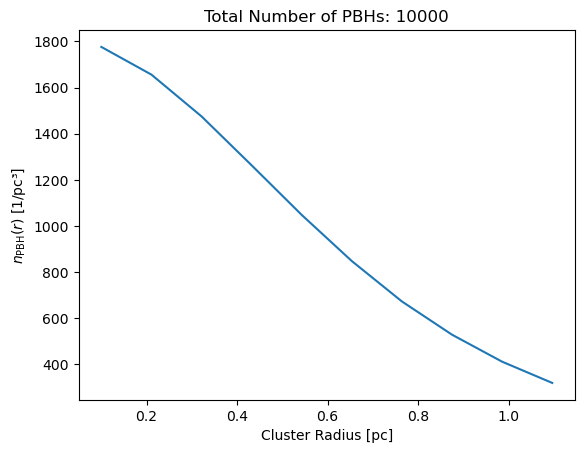

In [4]:
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1  + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    #output in (1/u.pc**3)
    return (rho(r) / M_pbh)

# Evaluar densidad numérica en cada radio
n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [5]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    phi_r_value = phi_r*9.5214e26 
    #output in (km^2/s^2)
    return phi_r_value

for radius in r_values_pc:
    print(phi(radius, M_DM_cluster))

390.74923700544997
385.3191670414023
376.5236635282478
365.0395257503717
351.63076228294216
337.03435865960034
321.8850809324169
306.6823600732552
291.7891134283598
277.44886626681006


In [6]:
# Función de distribución de energía
def f_E(E, N_pbh, M_cluster):
    E = E/9.5214e26 #.to(u.pc**2 / u.s**2)
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    f_E = (num / denom) # s^3 / pc^6
    f_E = f_E*3.404e-41 #(1 / (u.pc**3 * (u.km/u.s)**3))
    return f_E

# Integrando para la velocidad media cuadrática
def integrand(E_val, r, N_pbh, M_cluster):
    # E_val es escalar sin unidades
    E = E_val# * u.km**2 / u.s**2
    phi_val = phi(r, M_cluster)#*(u.km**2 / u.s**2)
    delta_E = (2 * (phi_val - E))#.to((u.km/u.s)**2)
    return (f_E(E, N_pbh, M_cluster) * delta_E**(1.5))#.value  # valor sin unidades


def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)  # 1/pc^3
    if n_r == 0:
        return 0.0# * u.km / u.s

    phi_r = phi(r, M_cluster)#.to(u.km**2 / u.s**2)

    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))

    v2 = (4 * np.pi / n_r) * integral# * (u.km**2 / u.s**2)
    v = np.sqrt(v2)#.to(u.km / u.s)
    return v#(u.km / u.s)


v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = 13.978
r = 0.21,  v_rms = 13.881
r = 0.32,  v_rms = 13.721
r = 0.43,  v_rms = 13.511
r = 0.54,  v_rms = 13.260
r = 0.65,  v_rms = 12.982
r = 0.76,  v_rms = 12.687
r = 0.87,  v_rms = 12.384
r = 0.99,  v_rms = 12.079
r = 1.10,  v_rms = 11.779

 v0 = 13.026


In [7]:
# Sección eficaz para formación de binarias (BBH)
def sigma_BPBH(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en unidades de M_sun
    v0: velocidad relativa en unidades de km/s
    retorna sección eficaz en unidades de pc²
    """
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    denom = c_astro**(10/7) * v0**(18/7)
    sigma_bpbh = (num / denom) * (3.085677581e13)**4 #.to(u.pc**2)
    return sigma_bpbh


# Sección eficaz para encuentros hiperbólicos cercanos (CHES)
def sigma_CHES(m1, m2, v0):
    v0 = v0 #(u.km / u.s)
    G_astro = G_ast #pc^3 / (s^2 solMass)
    c_astro = c_ast #km/s
    """
    m1, m2: masas en M_sun
    v0: velocidad relativa en km/s
    retorna sección eficaz en pc²
    """
    e = 1.01  # valor típico para encuentros no ligados
    b = (G_astro * (m1 + m2) / v0**2) #pc^3/km^2
    b = b/(3.085677581e13**-2)#.to(u.pc)
    sigma_ches = (np.pi * b**2 * (e**2 - 1)) #output pc^2
    return sigma_ches

In [8]:
sigma_bpbh = sigma_BPBH(M_PBH, M_PBH, v_0)
sigma_ches = sigma_CHES(M_PBH, M_PBH, v_0)

print(sigma_bpbh, sigma_ches)

1.7084941891440452e-12 1.6227718870801593e-08


In [9]:
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    km_to_pc = 1 / 3.085677581e13
    n_i = n_pbh(r_i, M_pbh_i) / 2  # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i)*km_to_pc# pc/s
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc# pc/s
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7) #(pc/s)^3/7
    result = r_i**2 * (n_i / v_i) * term #s^4/7 / pc^11/7
    return result

# Integral I(r_j) con separación de especies i y j
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)#[s^4/7 / pc^11/7]
    #Aquí las unidades cambian por las unidades del diferencial que dr tiene unidades de pc
    #[s^4/7 / pc^4/7] 
    return integral 

# Evaluación para todos los radios
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc #[s^4/7 / pc^4/7] 
])

# Ajuste polinomial
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma considerando especies i y j por separado
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2 # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j)*km_to_pc#pc/s
    if v_j == 0 or n_j == 0:
        return 0
    I_val = np.polyval(coeffs, r_j)
    result = ((v_0)**18/7)*(14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    
    return result

In [10]:
# Conversión constante
km_to_pc = 1 / 3.085677581e13  # [pc/km]
v_0_pc = v_0 * km_to_pc        # [pc/s], v_0 ya está definido en tu código

# Integrando de la integral I(r_j)
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    n_i = n_pbh(r_i, M_pbh_i) / 2                          # [1/pc³]
    v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc  # [pc/s]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]
    
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)       # [(pc/s)^(3/7)]
    result = r_i**2 * (n_i / v_i) * term                   # [pc² * (1/pc³) / (pc/s) * (pc/s)^(3/7)]
    # = [s^(-10/7) / pc^(11/7)]
    return result

# Integral I(r_j)
def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    # Resultado: [s^(-10/7) / pc^(4/7)]
    return integral

# Evaluación para todos los radios r_j
I_values = np.array([
    I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

# Ajuste polinomial en r_j
coeffs = np.polyfit(r_values_pc, I_values, 3)

# Tasa Gamma con todo en pc y s
def Gamma_rj(r_j, sigma, N_pbh_j, M_pbh_j, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j) / 2                          # [1/pc³]
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)                        # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    # (pc/s)^(18/7) * pc² * (1/pc³ / pc/s) * [s^(-10/7)/pc^(4/7)]
    
    return gamma     # [1/s]


In [11]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, sigma_bpbh, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, sigma_ches, N_PBH_j_Msun, M_PBH, M_PBH, M_DM_cluster)
    for r_j in r_values_pc
])

## First Generation

> *"In the silence of the early cosmos, they were born —  
> not of stars, but of solitude; destined to meet  
> where light cannot speak."*

In [12]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

# Número de fusiones esperadas en la edad del universo
mergers_total = Gamma_values_yr * age_universe_yr

# Tiempo estimado hasta la primera fusión (en años y luego Gyr)
time_first_merger_yr = 1 / Gamma_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

# Imprimir resultados
print(f"{'r_j (pc)':<12}{'Gamma (yr^-1)':<15}{'T_merger in UT':<17}{'Time to 1st merger (Gyr)'}")
print("=" * 70)
for i in range(len(r_values_pc)):
    print(f"{r_values_pc[i]:<12.1f}{Gamma_values_yr[i]:<15.3e}{mergers_total[i]:<17.6e}{time_first_merger_Gyr[i]:.3e}")


r_j (pc)    Gamma (yr^-1)  T_merger in UT   Time to 1st merger (Gyr)
0.1         6.886e-11      9.493022e-01     1.452e+01
0.2         6.561e-11      9.045133e-01     1.524e+01
0.3         6.030e-11      8.313300e-01     1.658e+01
0.4         5.354e-11      7.381199e-01     1.868e+01
0.5         4.605e-11      6.348652e-01     2.172e+01
0.7         3.849e-11      5.306742e-01     2.598e+01
0.8         3.136e-11      4.323169e-01     3.189e+01
0.9         2.494e-11      3.438821e-01     4.009e+01
1.0         1.938e-11      2.671670e-01     5.160e+01
1.1         1.468e-11      2.023473e-01     6.813e+01


In [13]:
# --- Tiempo característico delta_t ---
delta_t = np.min(time_first_merger_yr)/10  # en años

print("\nMinimum time to get 1st Generation:")
print(f"T_merger = {delta_t/1e9:<.3f} Gyr")

# --- Probabilidades de formación/emisión en ese intervalo ---
Prob_BPBH_form = Gamma_values_yr * delta_t       # adimensional
Prob_CHES_emit = Gamma_CHES_values_yr * delta_t  # adimensional

# Número esperado de colisiones por cascarón (adimensional * número de PBHs en el cascarón)
N_collisions = np.round(Prob_BPBH_form * n_PBH_r)  # array
N_CHES = np.round(Prob_CHES_emit * n_PBH_r)
# --- Imprimir resultados ---
print(f"{'Gamma (yr^-1)':<15}{'n_PBH(r)':<15}{'N_collisions':<18}{'N_CHES':<10}")
print("=" * 60)
for i in range(len(r_values_pc)):
    print(f"{Gamma_values_yr[i]:<15.3e}{n_PBH_r[i]:<15.1f}{N_collisions[i]:<18.1f}{N_CHES[i]:<10.1f}")


Minimum time to get 1st Generation:
T_merger = 1.452 Gyr
Gamma (yr^-1)  n_PBH(r)       N_collisions      N_CHES    
6.886e-11      1776.0         178.0             1686891.0 
6.561e-11      1656.0         158.0             1498700.0 
6.030e-11      1475.0         129.0             1226888.0 
5.354e-11      1263.0         98.0              932760.0  
4.605e-11      1048.0         70.0              665706.0  
3.849e-11      848.0          47.0              450260.0  
3.136e-11      673.0          31.0              291110.0  
2.494e-11      529.0          19.0              182014.0  
1.938e-11      412.0          12.0              110134.0  
1.468e-11      320.0          7.0               64787.0   


Final Mass = 17.5 M_sun


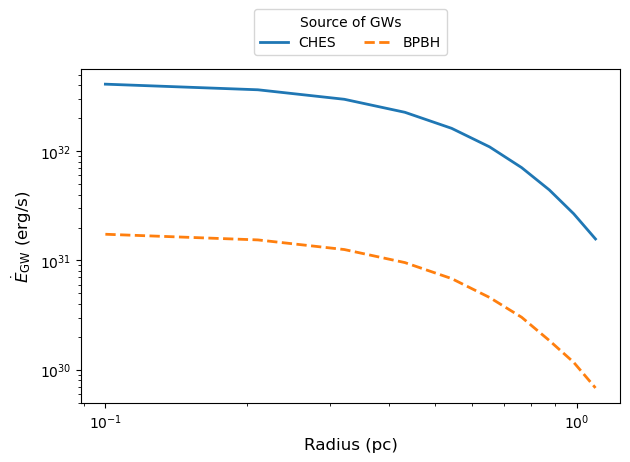

In [14]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

# --- Parámetros de separación inicial y final ---
a0 = (2 * G_SI * M_PBH * Msun_kg) / c_SI**2 / pc_m   # pc
a1 = 0.1 * AU_pc                                     # pc

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2, a0, a1):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2, a0, a1):
    E_rad = E_rad_GW(m1, m2, a0, a1) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.01, K=5):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH, a0, a1)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH, a0, a1)       # M_sun

print(f"Final Mass = {final_masses:.1f} M_sun")

# --- delta_t en segundos ---
delta_t_sec = delta_t * 1e9 * seconds_per_year

# --- Potencias totales por cascarón ---
E_dot_BBH_shell = N_collisions * E_BBH_event / delta_t_sec  # erg/s
E_dot_CHES_shell = N_CHES * E_CHES_event / delta_t_sec      # erg/s

# --- Gráfica de potencias radiadas ---
plt.plot(r_values_pc, E_dot_CHES_shell, label='CHES', linewidth=2, linestyle='-')
plt.plot(r_values_pc, E_dot_BBH_shell, label='BPBH', linewidth=2, linestyle='--')


plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(title = "Source of GWs", loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=True)
#plt.title("Total Power Radiated from BPBH and CHES", fontsize=14)
plt.tight_layout()
plt.savefig("BPBH&CHES.pdf", dpi=300, bbox_inches="tight")
plt.show()




## Second Generation
> *"Bound not by threads, but by gravity's gaze,  
> they embraced through the void, weaving echoes  
> into the fabric of time."*

In [15]:
N_PBH_1G = np.sum(N_collisions) #PBHs de primera generación
M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_tot_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_tot_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = 1e5 - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")



Number of PBHs of initial generation: 8502 of 10.00 Solar Mass
Number of PBHs of 1st generation:     749 of 17.50 Solar Mass
Cluster Mass after 1st generation:    9.8128e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       1872.4963 Solar Mass
Percentage of Cluster Mass Lost by GWs: 1.9%


In [16]:
M_DM_cluster = M_DM_c_1G

N_0G = n_PBH_r - 2 * N_collisions
N_1G = N_collisions

#print(N_0G, N_1G)
#print(np.sum(N_0G), np.sum(N_1G))

from itertools import combinations_with_replacement

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": N_0G, "M": M_PBH},
    {"name": "1G", "N_array": N_1G, "M": final_masses}
]

#n_PBH_r - 2 * N_collisions#, N_collisions)

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos = []

E_dot_BBH_dict = {}
E_dot_CHES_dict = {}
M_dict = {}
N_coll_BPBH_dict = {}
N_coll_CHES_dict = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(Prob_form * N_i_array)
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict[f'{nombre_i}-{nombre_j}']:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })


Evaluando interacción 0G-0G...
Masses interacting
M_PBH_0G: 10.00
M_PBH_0G: 10.00
Mass_final_from_0G-0G: 17.50

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      1.502e-10      1.427e-06        6.658e+00           320.0     3038650.0
0.21      1.491e-10      1.416e-06        6.707e+00           300.0     2846450.0
0.32      1.465e-10      1.392e-06        6.825e+00           267.0     2538323.0
0.43      1.423e-10      1.352e-06        7.026e+00           228.0     2165802.0
0.54      1.361e-10      1.293e-06        7.347e+00           185.0     1760802.0
0.65      1.282e-10      1.217e-06        7.803e+00           145.0     1376729.0
0.76      1.184e-10      1.124e-06        8.447e+00           109.0     1032190.0
0.87      1.075e-10      1.021e-06        9.299e+00           79.0      753785.0
0.99      9.516e-11      9.039e-07        1.051e+01           55.0      526041.0
1.10      8.235e-11      7.821e-07        1.214e+01           38.0  

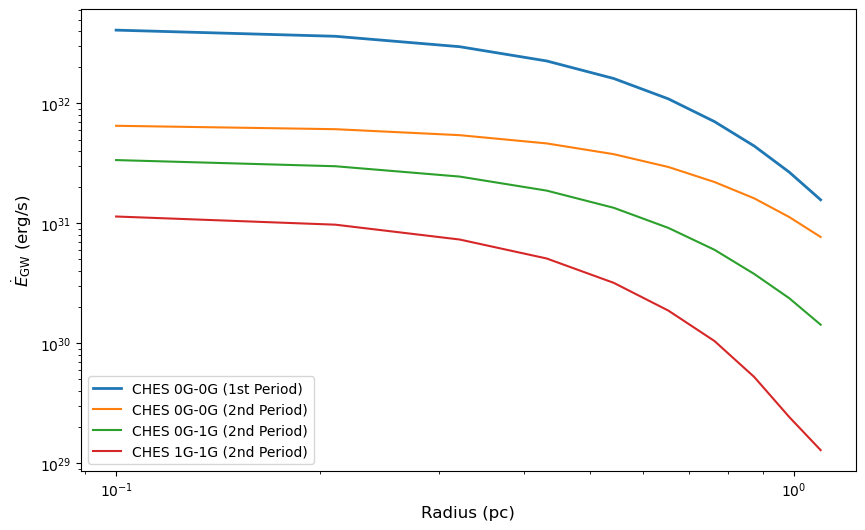

In [28]:
#print(E_dot_CHES_dict["0G-0G"])
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
for key in E_dot_CHES_dict:
    plt.loglog(r_values_pc, E_dot_CHES_dict[key], linestyle="solid", label=f"CHES {key} (2nd Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.savefig("CHES_2.pdf", dpi=300, bbox_inches="tight")
plt.show()

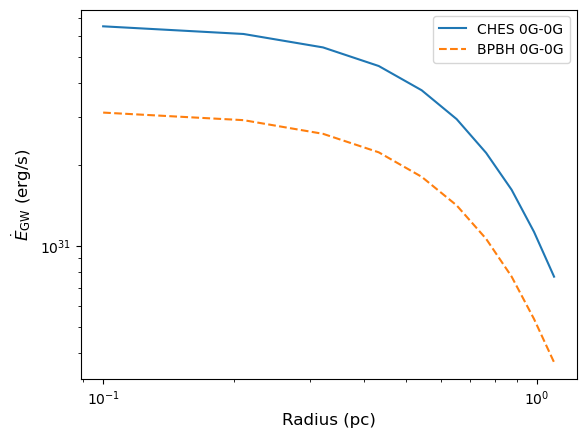

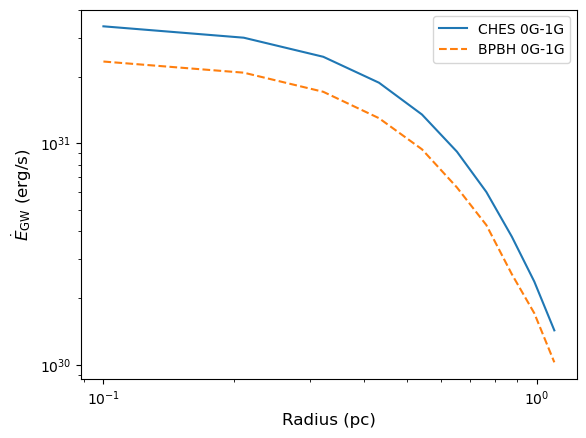

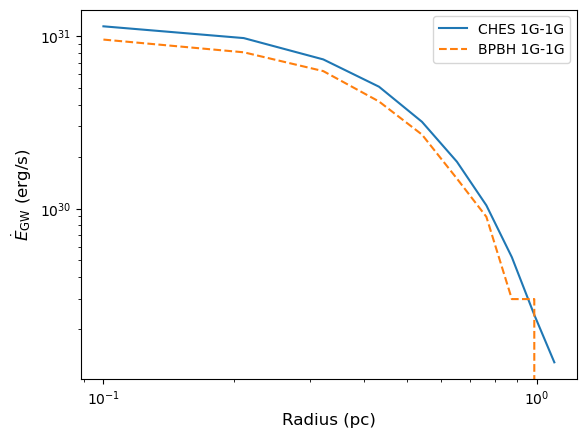

In [29]:
for key in E_dot_BBH_dict:
    plt.plot(r_values_pc, E_dot_CHES_dict[key], linestyle="solid", label=f"CHES {key}")
    plt.plot(r_values_pc, E_dot_BBH_dict[key], linestyle="--",label=f"BPBH {key}")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Radius (pc)", fontsize=12)
    plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
    plt.legend()
    filename = f"BPBH_CHES_{key.replace('–', '-')}.pdf"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

## Third Generation
> *"Each collision a verse, each merger a vow — shaping the darkness into rhythm, into memory, into mass."*


In [19]:
M_0G = M_PBH_0G #Masa de la población original
M_1G = resultados_discretos[0]['Mass_final'] #Masa resultante de 0G-0G.
M_2G_a = resultados_discretos[1]['Mass_final'] #Masa resultante de 0G-1G
M_2G_b = resultados_discretos[2]['Mass_final'] #Masa resultante de 1G-1G

N_2G_b = resultados_discretos[2]['N_collisions_BBH'] #
N_2G_a = resultados_discretos[1]['N_collisions_BBH'] #

#print(N_0G, N_1G)

N_0G_second = N_0G - (2*(resultados_discretos[0]['N_collisions_BBH'])+ N_2G_a)#
#print(np.sum(N_0G_second)*M_0G)
N_1G_second = (N_1G - (N_2G_a + 2*N_2G_b)) + resultados_discretos[0]['N_collisions_BBH'] #
#print(np.sum(N_1G_second)*M_1G)
#print(np.sum(N_2G_a)*M_2G_a)
#print(np.sum(N_2G_b)*M_2G_b)


M_DM_c_2G = (np.sum(N_0G_second)*M_0G) + (np.sum(N_1G_second)*M_1G) + (np.sum(N_2G_a)*M_2G_a) + (np.sum(N_2G_b)*M_2G_b)
M_LOST_GW = M_DM_cluster - M_DM_c_2G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100


print(f"Number of PBHs of initial generation: {np.sum(N_0G_second)} of {M_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {np.sum(N_1G_second)} of {M_1G:.2f} Solar Mass")
print(f"Number of PBHs of 2nd generation_a:   {np.sum(N_2G_a)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of PBHs of 2nd generation_b:   {np.sum(N_2G_b)} of {M_2G_b:.2f} Solar Mass")
print(f"Cluster Mass after 2nd generation:    {M_DM_c_2G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

Number of PBHs of initial generation: 4467.0 of 10.00 Solar Mass
Number of PBHs of 1st generation:     1666.0 of 17.50 Solar Mass
Number of PBHs of 2nd generation_a:   583.0 of 23.13 Solar Mass
Number of PBHs of 2nd generation_b:   113.0 of 27.34 Solar Mass
Cluster Mass after 2nd generation:    9.0397e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       7.7308e+03 Solar Mass
Percentage of Cluster Mass Lost by GWs: 7.9%


In [33]:
M_DM_cluster = M_DM_c_2G

especies = [
    {"name": "0G", "N_array": N_0G_second, "M": M_0G},
    {"name": "1G", "N_array": N_1G_second, "M": M_1G},
    {"name": "2G_a", "N_array": N_2G_a, "M": M_2G_a},
    {"name": "2G_b", "N_array": N_2G_b, "M": M_2G_b},
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos_3rd = []

E_dot_BBH_dict_3 = {}
E_dot_CHES_dict_3 = {}
M_dict_3 = {}
N_coll_BPBH_dict_3 = {}
N_coll_CHES_dict_3 = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(Prob_form * N_i_array)
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict_3[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict_3[f'{nombre_i}-{nombre_j}']:.4f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    #print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    print(f"Total BPBH events = {int(np.sum(N_coll_BBH))}")
    print("=" * 80)
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos_3rd.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })


Evaluando interacción 0G-0G...
Masses interacting
M_PBH_0G: 10.00
M_PBH_0G: 10.00
Mass_final_from_0G-0G: 17.5000

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      1.120e-10      1.063e-06        8.932e+00           108.0     1027278.0
0.21      1.121e-10      1.065e-06        8.922e+00           104.0     986825.0
0.32      1.124e-10      1.068e-06        8.898e+00           98.0      935140.0
0.43      1.116e-10      1.060e-06        8.959e+00           90.0      852354.0
0.54      1.100e-10      1.045e-06        9.091e+00           80.0      758509.0
0.65      1.069e-10      1.015e-06        9.356e+00           69.0      651731.0
0.76      1.016e-10      9.651e-07        9.842e+00           56.0      532740.0
0.87      9.570e-11      9.089e-07        1.045e+01           46.0      433562.0
0.99      8.754e-11      8.315e-07        1.142e+01           35.0      334260.0
1.10      7.799e-11      7.407e-07        1.282e+01           26.0      

/var/folders/8z/v5ctqgzj6976wfqxw2yn2m1w0000gn/T/ipykernel_18928/2272688508.py:74: RuntimeWarning: divide by zero encountered in divide
  time_first_merger_yr = 1 / Gamma_values_yr


Masses interacting
M_PBH_0G: 10.00
M_PBH_2G_b: 27.34
Mass_final_from_0G-2G_b: 30.5078

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      1.403e-11      1.429e-07        7.126e+01           27.0      275605.0
0.21      1.288e-11      1.312e-07        7.761e+01           24.0      243208.0
0.32      1.136e-11      1.157e-07        8.803e+01           20.0      202272.0
0.43      9.273e-12      9.440e-08        1.078e+02           15.0      151519.0
0.54      7.432e-12      7.567e-08        1.345e+02           11.0      109647.0
0.65      5.537e-12      5.638e-08        1.806e+02           7.0       72218.0
0.76      4.286e-12      4.364e-08        2.333e+02           5.0       48179.0
0.87      2.473e-12      2.518e-08        4.044e+02           2.0       24018.0
0.99      2.471e-12      2.516e-08        4.046e+02           2.0       20230.0
1.10      0.000e+00      0.000e+00        inf                 0.0       0.0
Total BPBH events = 113

Eval

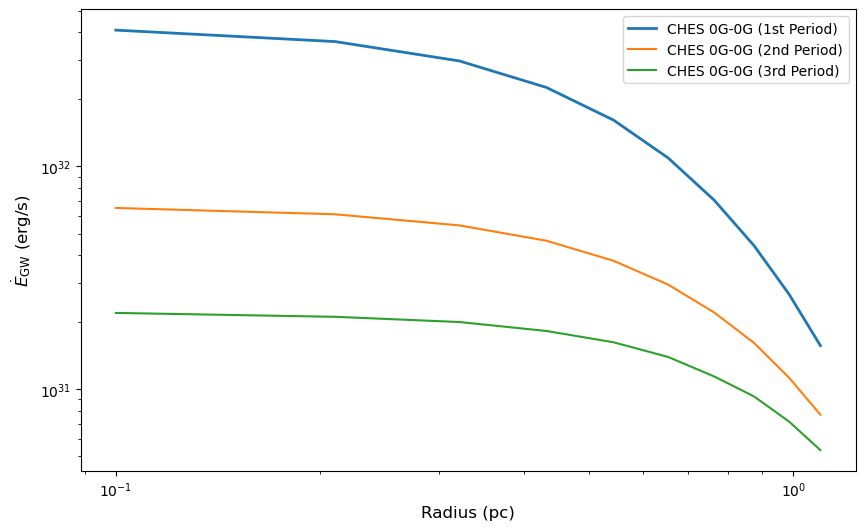

In [27]:
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
plt.loglog(r_values_pc, E_dot_CHES_dict["0G-0G"], linestyle="solid", label="CHES 0G-0G (2nd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_3["0G-0G"], linestyle="solid", label="CHES 0G-0G (3rd Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.savefig("CHES_3.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [54]:
#print(2*resultados_discretos_3rd[0]['N_collisions_BBH'])
#print(resultados_discretos_3rd[1]['N_collisions_BBH'])
#print(resultados_discretos_3rd[2]['N_collisions_BBH'])
#print(resultados_discretos_3rd[3]['N_collisions_BBH'])
#print("\n")
#print(N_0G_second)
#print(N_0G_second - (2*resultados_discretos_3rd[0]['N_collisions_BBH'] +
#                     resultados_discretos_3rd[1]['N_collisions_BBH'] +
#                    resultados_discretos_3rd[2]['N_collisions_BBH'] +
#                    resultados_discretos_3rd[3]['N_collisions_BBH']))

N_0G_third = N_0G_second - (2*resultados_discretos_3rd[0]['N_collisions_BBH'] +
                     resultados_discretos_3rd[1]['N_collisions_BBH'] +
                    resultados_discretos_3rd[2]['N_collisions_BBH'] +
                    resultados_discretos_3rd[3]['N_collisions_BBH'])
print(N_0G_third, "=> tot:",np.sum(N_0G_third))

[ 75.  87. 105. 122. 138. 149. 154. 155. 148. 139.] => tot: 1272.0


In [61]:
N_1G_third = N_1G_second - (resultados_discretos_3rd[1]['N_collisions_BBH'] + 
                    2*resultados_discretos_3rd[4]['N_collisions_BBH'] + 
                    resultados_discretos_3rd[5]['N_collisions_BBH'] + 
                    resultados_discretos_3rd[6]['N_collisions_BBH']) + resultados_discretos_3rd[0]['N_collisions_BBH']
print(N_1G_third, "=> tot:",np.sum(N_1G_third))

[ 8. 17. 30. 44. 53. 59. 56. 50. 41. 32.] => tot: 390.0


In [65]:
N_2G_a_third = N_2G_a - (resultados_discretos_3rd[2]['N_collisions_BBH'] + 
                         resultados_discretos_3rd[5]['N_collisions_BBH'] + 
                         2*resultados_discretos_3rd[7]['N_collisions_BBH'] +
                         resultados_discretos_3rd[8]['N_collisions_BBH']) + resultados_discretos_3rd[1]['N_collisions_BBH']
print(N_2G_a_third, "=> tot:",np.sum(N_2G_a_third))

[124. 118. 110. 101.  85.  71.  55.  42.  29.  21.] => tot: 756.0


In [69]:
N_2G_b_third = N_2G_b - (resultados_discretos_3rd[3]['N_collisions_BBH'] +
                        resultados_discretos_3rd[6]['N_collisions_BBH'] +
                        resultados_discretos_3rd[8]['N_collisions_BBH'] +
                        2*resultados_discretos_3rd[9]['N_collisions_BBH']) + resultados_discretos_3rd[4]['N_collisions_BBH']

print(N_2G_b_third, "=> tot:",np.sum(N_2G_b_third))

[19. 19. 20. 20. 16. 14.  8.  7.  4.  3.] => tot: 130.0


In [87]:
_3G_a = resultados_discretos_3rd[2]['N_collisions_BBH']
N_3G_A = N_2G_b_third + _3G_a #Mass_27.34
print(N_3G_A)

_3G_b = resultados_discretos_3rd[3]['N_collisions_BBH']
_3G_c = resultados_discretos_3rd[5]['N_collisions_BBH']
N_3G_B = _3G_b + _3G_c #Mass_30.50
print(N_3G_B)

_3G_d = resultados_discretos_3rd[6]['N_collisions_BBH']
_3G_e = resultados_discretos_3rd[7]['N_collisions_BBH']
N_3G_C = _3G_d + _3G_e #Mass_32.88
print(N_3G_C)


N_3G_D = resultados_discretos_3rd[8]['N_collisions_BBH']
print(N_3G_D) #Mass_34.66

N_3G_E = resultados_discretos_3rd[9]['N_collisions_BBH']
print(N_3G_E) #Mass_35.99

[127. 116. 103.  86.  67.  51.  34.  24.  16.  11.]
[92. 82. 68. 51. 36. 23. 15.  8.  5.  2.]
[37. 33. 26. 18. 12.  7.  4.  2.  1.  0.]
[13. 11.  8.  5.  3.  1.  1.  0.  0.  0.]
[4. 4. 2. 1. 1. 0. 0. 0. 0. 0.]


## Four generation
> *"From the ashes of collisions past, new masses rise — whispers of gravity composing their eternal symphony."*


In [88]:
M_0G = M_PBH_0G
M_1G_third = resultados_discretos_3rd[0]['Mass_final']
M_2G_third = resultados_discretos_3rd[1]['Mass_final']
M_3G_A = resultados_discretos_3rd[2]['Mass_final']
M_3G_B = resultados_discretos_3rd[3]['Mass_final']
M_3G_C = resultados_discretos_3rd[6]['Mass_final']
M_3G_D = resultados_discretos_3rd[8]['Mass_final']
M_3G_E = resultados_discretos_3rd[9]['Mass_final']


suma_M_tot_PBHs = (
    np.sum(N_0G_third)*M_0G +
    np.sum(N_1G_third)*M_1G_third +
    np.sum(N_2G_a_third)*M_2G_third +
    np.sum(N_3G_A)*M_3G_A +
    np.sum(N_3G_B)*M_3G_B +
    np.sum(N_3G_C)*M_3G_C +
    np.sum(N_3G_D)*M_3G_D +
    np.sum(N_3G_E)*M_3G_E
)

N_0G_third
N_1G_third
N_2G_a_third
N_3G_A
N_3G_B
N_3G_C
N_3G_D
N_3G_E

M_DM_c_3G = suma_M_tot_PBHs
M_LOST_GW = M_DM_cluster - M_DM_c_3G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100


print(f"Number of PBHs of initial generation: {np.sum(N_0G_third)} of {M_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {np.sum(N_1G_third)} of {M_1G:.2f} Solar Mass")
print(f"Number of PBHs of 2nd generation:     {np.sum(N_2G_a_third)} of {M_2G_third:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_A:   {np.sum(N_3G_A)} of {M_3G_A:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_B:   {np.sum(N_3G_B)} of {M_3G_B:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_C:   {np.sum(N_3G_C)} of {M_3G_C:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_D:   {np.sum(N_3G_D)} of {M_3G_D:.2f} Solar Mass")
print(f"Number of PBHs of 3rd generation_E:   {np.sum(N_3G_E)} of {M_3G_E:.2f} Solar Mass")

print(f"Cluster Mass after 3rd generation:    {M_DM_c_3G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

Number of PBHs of initial generation: 1272.0 of 10.00 Solar Mass
Number of PBHs of 1st generation:     390.0 of 17.50 Solar Mass
Number of PBHs of 2nd generation:     756.0 of 23.13 Solar Mass
Number of PBHs of 3rd generation_A:   635.0 of 27.34 Solar Mass
Number of PBHs of 3rd generation_B:   382.0 of 30.51 Solar Mass
Number of PBHs of 3rd generation_C:   140.0 of 32.88 Solar Mass
Number of PBHs of 3rd generation_D:   42.0 of 34.66 Solar Mass
Number of PBHs of 3rd generation_E:   12.0 of 36.00 Solar Mass
Cluster Mass after 3rd generation:    7.2536e+04 Solar Mass
Mass lost by GWs (BPBH mergers):       1.7861e+04 Solar Mass
Percentage of Cluster Mass Lost by GWs: 19.8%


In [89]:
M_DM_cluster = M_DM_c_3G

especies = [
    {"name": "0G", "N_array": N_0G_third, "M": M_0G},
    {"name": "1G", "N_array": N_1G_third, "M": M_1G},
    {"name": "2G", "N_array": N_2G_a_third, "M": M_2G_third},
    {"name": "3G_A", "N_array": N_3G_A, "M": M_3G_A},
    {"name": "3G_B", "N_array": N_3G_B, "M": M_3G_B},
    {"name": "3G_C", "N_array": N_3G_C, "M": M_3G_C},
    {"name": "3G_D", "N_array": N_3G_D, "M": M_3G_D},
    {"name": "3G_E", "N_array": N_3G_E, "M": M_3G_E},
]

# --- Generar combinaciones con reemplazo: (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []

for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    # Si son de la misma especie (0G–0G o 1G–1G), dividir a la mitad
    if nombre_i == nombre_j:
        N_i_array = np.round(N_i_array / 2)
        N_j_array = np.round(N_j_array / 2)

    combinaciones_preparadas.append((nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j))

def evaluar_I_rj_por_combinacion(N_i, M_i, N_j, M_j, M_cluster):
    """
    Calcula I(r_j) para cada cascarón y devuelve sus coeficientes polinomiales.
    Los parámetros N_i y N_j pueden ser escalares (sumas por especie).
    """
    I_values = np.array([
        I_rj(r_j, N_i, M_i, N_j, M_j, M_cluster)
        for r_j in r_values_pc
    ])
    coeffs = np.polyfit(r_values_pc, I_values, 3)
    return I_values, coeffs

# --- Nueva función para Gamma usando arrays discretos ---
def Gamma_rj_discreto(j, r_j, sigma, N_j_array, M_j, M_i, M_cluster, coeffs):
    n_j = N_j_array[j]  # número de PBHs tipo j en el cascarón j
    v_j = mean_square_velocity(r_j, M_cluster, N_j_array[j], M_j) * km_to_pc  # [pc/s]

    if v_j == 0 or n_j == 0:
        return 0

    I_val = np.polyval(coeffs, r_j)  # [s^(-10/7) / pc^(4/7)]

    gamma = (v_0_pc)**(18/7) * (14 * np.pi / 3) * sigma * (n_j / v_j) * I_val
    return gamma  # [1/s]

# --- Evaluación por cada combinación de especies ---
resultados_discretos_4th = []

E_dot_BBH_dict_4 = {}
E_dot_CHES_dict_4 = {}
M_dict_4 = {}
N_coll_BPBH_dict_4 = {}
N_coll_CHES_dict_4 = {}

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # ----------------------
    # --- BBH CALCULATIONS --
    # ----------------------
    sigma_B = sigma_BPBH(M_i, M_j, v_0)

    I_vals, coeffs_ij = evaluar_I_rj_por_combinacion(np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)

    Gamma_values = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_B, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_values_yr = Gamma_values * seconds_per_year
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    # Tiempo característico
    delta_t_local = 3e9#np.min(time_first_merger_yr) / 10

    # Colisiones BBH
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(Prob_form * N_i_array)
    M_result = final_mass_GW(M_i, M_j, a0, a1)
    M_dict_4[f"{nombre_i}-{nombre_j}"] = M_result

    # Energía BBH
    E_BBH_event = E_rad_GW(M_i, M_j, a0, a1)
    E_dot_BBH = N_coll_BBH * E_BBH_event / delta_t_sec

    # ------------------------
    # --- CHES CALCULATIONS --
    # ------------------------
    G_ast = 4.517103049894964e-30  # pc³ / (s² M_sun)
    c_ast = 2.99792458e5           # km/s
    e = 1.01
    K = 10
    b = (G_ast * (M_i + M_j) / v_0**2) / (1 / (3.085677581e13)**2)
    sigma_C = np.pi * b**2 * (e**2 - 1)

    Gamma_CHES = np.array([
        Gamma_rj_discreto(j, r_values_pc[j], sigma_C, N_j_array, M_j, M_i, M_DM_cluster, coeffs_ij)
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = Gamma_CHES * seconds_per_year
    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)

    E_CHES_event = E_rad_CHES(M_i, M_j, e, K)
    E_dot_CHES = N_coll_CHES * E_CHES_event / delta_t_sec

    # ------------------------
    # --- Print Tab --
    # ------------------------
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict_4[f'{nombre_i}-{nombre_j}']:.4f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")
    
    #Discret_results
    N_coll_BPBH_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_CHES


    # ----------------------------
    # --- Summary 
    # ----------------------------
    #print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    #print(f"Σ_BBH = {sigma_B:.2e} pc²")
    #print(f"Σ_CHES = {sigma_C:.2e} pc²")
    #print(f"E_BBH per event = {E_BBH_event:.2e} erg")
    #print(f"E_CHES per event = {E_CHES_event:.2e} erg")
    print(f"Total BPBH events = {int(np.sum(N_coll_BBH))}")
    print("=" * 80)
    #print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    #print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg/s")
    #print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg/s")

    # --- Save Results ---
    resultados_discretos_4th.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })


Evaluando interacción 0G-0G...
Masses interacting
M_PBH_0G: 10.00
M_PBH_0G: 10.00
Mass_final_from_0G-0G: 17.5000

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      4.418e-11      4.196e-07        2.263e+01           5.0       47840.0
0.21      4.858e-11      4.614e-07        2.058e+01           6.0       60910.0
0.32      5.448e-11      5.175e-07        1.835e+01           8.0       80727.0
0.43      6.117e-11      5.810e-07        1.635e+01           11.0      106322.0
0.54      6.747e-11      6.408e-07        1.482e+01           14.0      132654.0
0.65      7.219e-11      6.857e-07        1.385e+01           16.0      152231.0
0.76      7.551e-11      7.172e-07        1.324e+01           17.0      165666.0
0.87      7.699e-11      7.313e-07        1.299e+01           18.0      171122.0
0.99      7.473e-11      7.098e-07        1.338e+01           17.0      157574.0
1.10      7.082e-11      6.727e-07        1.412e+01           15.0      1412

/var/folders/8z/v5ctqgzj6976wfqxw2yn2m1w0000gn/T/ipykernel_18928/2851140657.py:78: RuntimeWarning: divide by zero encountered in divide
  time_first_merger_yr = 1 / Gamma_values_yr


Masses interacting
M_PBH_0G: 10.00
M_PBH_3G_C: 32.88
Mass_final_from_0G-3G_C: 34.6607

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      4.972e-11      5.197e-07        2.011e+01           11.0      116932.0
0.21      4.687e-11      4.899e-07        2.134e+01           12.0      127864.0
0.32      4.151e-11      4.338e-07        2.409e+01           13.0      136660.0
0.43      3.444e-11      3.600e-07        2.903e+01           13.0      131762.0
0.54      2.803e-11      2.930e-07        3.567e+01           12.0      121316.0
0.65      2.134e-11      2.230e-07        4.687e+01           10.0      99691.0
0.76      1.607e-11      1.679e-07        6.224e+01           7.0       77589.0
0.87      1.132e-11      1.183e-07        8.837e+01           5.0       55003.0
0.99      7.973e-12      8.334e-08        1.254e+02           4.0       37004.0
1.10      0.000e+00      0.000e+00        inf                 0.0       0.0
Total BPBH events = 87

Evalu

Masses interacting
M_PBH_1G: 17.50
M_PBH_3G_C: 32.88
Mass_final_from_1G-3G_C: 35.9955

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      7.817e-11      7.635e-07        1.279e+01           2.0       18325.0
0.21      7.321e-11      7.151e-07        1.366e+01           4.0       36469.0
0.32      6.435e-11      6.285e-07        1.554e+01           6.0       56567.0
0.43      5.296e-11      5.173e-07        1.888e+01           7.0       68279.0
0.54      4.273e-11      4.174e-07        2.340e+01           7.0       66362.0
0.65      3.223e-11      3.148e-07        3.102e+01           6.0       55726.0
0.76      2.406e-11      2.350e-07        4.156e+01           4.0       39485.0
0.87      1.681e-11      1.642e-07        5.948e+01           3.0       24634.0
0.99      1.177e-11      1.150e-07        8.497e+01           1.0       14139.0
1.10      0.000e+00      0.000e+00        inf                 0.0       0.0
Total BPBH events = 40

Evaluando 

Masses interacting
M_PBH_2G: 23.13
M_PBH_3G_D: 34.66
Mass_final_from_2G-3G_D: 37.7475

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      1.006e-11      9.666e-08        9.941e+01           4.0       35959.0
0.21      9.249e-12      8.888e-08        1.081e+02           3.0       31462.0
0.32      7.884e-12      7.576e-08        1.268e+02           3.0       25001.0
0.43      6.231e-12      5.987e-08        1.605e+02           2.0       18142.0
0.54      4.825e-12      4.636e-08        2.073e+02           1.0       11822.0
0.65      2.784e-12      2.675e-08        3.592e+02           1.0       5698.0
0.76      2.782e-12      2.673e-08        3.595e+02           0.0       4411.0
0.87      0.000e+00      0.000e+00        inf                 0.0       0.0
0.99      0.000e+00      0.000e+00        inf                 0.0       0.0
1.10      0.000e+00      0.000e+00        inf                 0.0       0.0
Total BPBH events = 14

Evaluando interacció

Masses interacting
M_PBH_3G_B: 30.51
M_PBH_3G_B: 30.51
Mass_final_from_3G_B-3G_B: 37.7475

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      8.696e-11      8.260e-07        1.150e+01           12.0      113989.0
0.21      8.390e-11      7.969e-07        1.192e+01           10.0      98017.0
0.32      7.881e-11      7.486e-07        1.269e+01           8.0       76356.0
0.43      7.144e-11      6.786e-07        1.400e+01           6.0       52930.0
0.54      6.165e-11      5.856e-07        1.622e+01           3.0       31621.0
0.65      5.201e-11      4.940e-07        1.923e+01           2.0       17785.0
0.76      4.354e-11      4.136e-07        2.297e+01           1.0       9925.0
0.87      3.119e-11      2.963e-07        3.206e+01           0.0       3555.0
0.99      2.198e-11      2.088e-07        4.550e+01           0.0       1253.0
1.10      1.514e-11      1.438e-07        6.603e+01           0.0       432.0
Total BPBH events = 42

Evalua

Masses interacting
M_PBH_3G_D: 34.66
M_PBH_3G_D: 34.66
Mass_final_from_3G_D-3G_D: 39.2874

r_j (pc)  Γ_BBH (yr^-1)  Γ_CHES (yr^-1)   T_1st merge (Gyr)   N_BBH     N_CHES    
0.10      6.160e-11      5.851e-07        1.623e+01           1.0       10531.0
0.21      6.294e-11      5.979e-07        1.589e+01           1.0       10762.0
0.32      5.302e-11      5.036e-07        1.886e+01           1.0       6043.0
0.43      3.886e-11      3.691e-07        2.573e+01           0.0       2215.0
0.54      4.030e-11      3.828e-07        2.481e+01           0.0       2297.0
0.65      0.000e+00      0.000e+00        inf                 0.0       0.0
0.76      0.000e+00      0.000e+00        inf                 0.0       0.0
0.87      0.000e+00      0.000e+00        inf                 0.0       0.0
0.99      0.000e+00      0.000e+00        inf                 0.0       0.0
1.10      0.000e+00      0.000e+00        inf                 0.0       0.0
Total BPBH events = 3

Evaluando interacción 3G_D

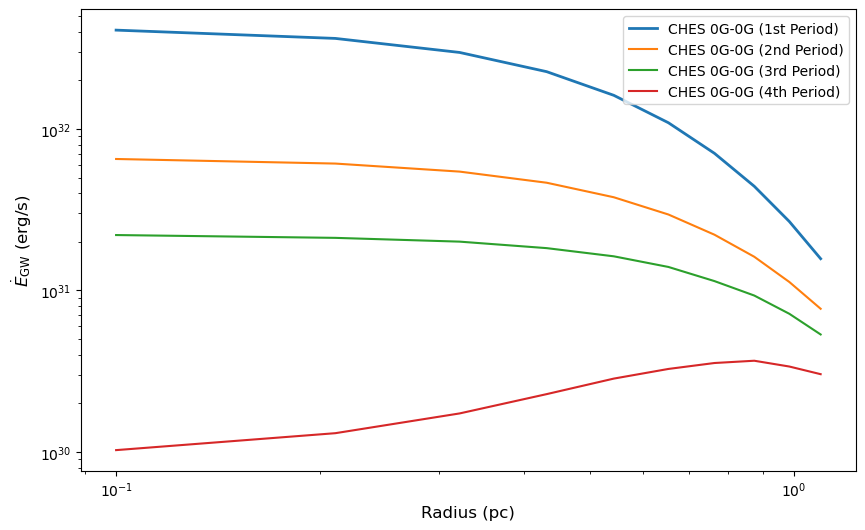

In [90]:
plt.figure(figsize=(10, 6))
plt.loglog(r_values_pc, E_dot_CHES_shell, label='CHES 0G-0G (1st Period)', linewidth=2, linestyle='solid')
plt.loglog(r_values_pc, E_dot_CHES_dict["0G-0G"], linestyle="solid", label="CHES 0G-0G (2nd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_3["0G-0G"], linestyle="solid", label="CHES 0G-0G (3rd Period)")
plt.loglog(r_values_pc, E_dot_CHES_dict_4["0G-0G"], linestyle="solid", label="CHES 0G-0G (4th Period)")
plt.xlabel("Radius (pc)", fontsize=12)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=12)
plt.legend()
plt.savefig("CHES_4.pdf", dpi=300, bbox_inches="tight")
plt.show()

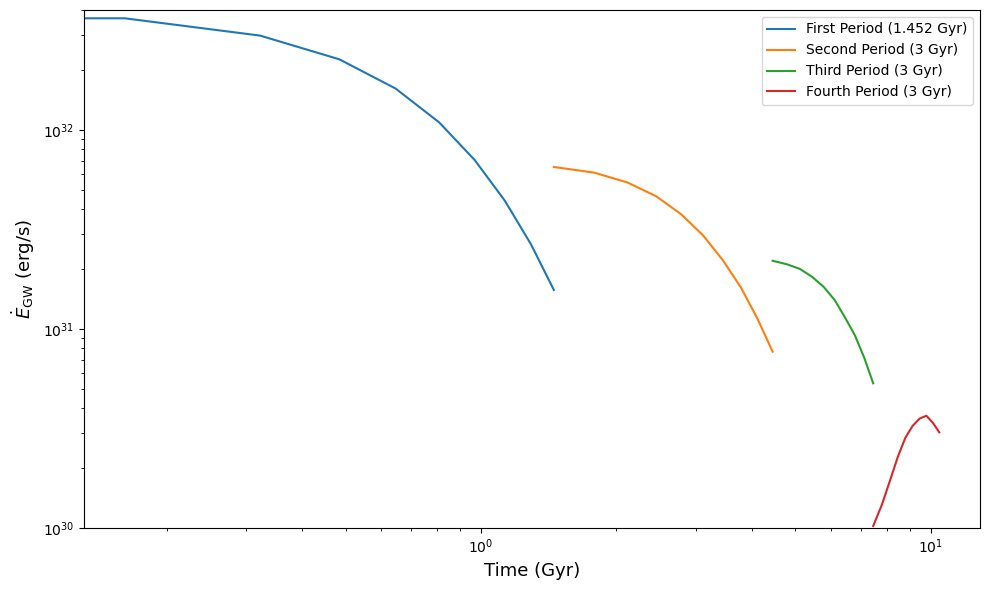

In [246]:
N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]               # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]        # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]      # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]      # Cuarto periodo

# Separar en arrays individuales para facilidad de uso
E_dot_period1 = E_dot_periods[:, 0]
E_dot_period2 = E_dot_periods[:, 1]
E_dot_period3 = E_dot_periods[:, 2]
E_dot_period4 = E_dot_periods[:, 3]

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

# IMPORTANTE:
# Cada periodo evoluciona a lo largo de un tiempo total conocido:
# Primer periodo: 1.452 Gyr, Segundo, Tercero y Cuarto: 3 Gyr cada uno.
# Como tenemos 10 radios evaluados por periodo, distribuimos estos 10 valores
# uniformemente en el tiempo total de cada etapa.

T_period1 = 1.452  # Gyr
T_period2 = 3.0    # Gyr
T_period3 = 3.0    # Gyr
T_period4 = 3.0    # Gyr

# Crear arrays de tiempo uniformemente espaciados para cada periodo
time_period1 = np.linspace(0, T_period1, N)
time_period2 = np.linspace(0, T_period2, N)
time_period3 = np.linspace(0, T_period3, N)
time_period4 = np.linspace(0, T_period4, N)

# --- 3. Preparar tiempos acumulados para graficar la evolución completa ---

# Desplazar los tiempos para representar la secuencia continua de evolución
time_period2_shifted = time_period2 + T_period1
time_period3_shifted = time_period3 + T_period1 + T_period2
time_period4_shifted = time_period4 + T_period1 + T_period2 + T_period3

# --- 4. (Opcional) Graficar evolución de la emisión de GW en el tiempo total ---

plt.figure(figsize=(10,6))

plt.plot(time_period1, E_dot_period1, label="First Period (1.452 Gyr)")
plt.plot(time_period2_shifted, E_dot_period2, label="Second Period (3 Gyr)")
plt.plot(time_period3_shifted, E_dot_period3, label="Third Period (3 Gyr)")
plt.plot(time_period4_shifted, E_dot_period4, label="Fourth Period (3 Gyr)")

plt.xlabel("Time (Gyr)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e30,4e32])
plt.legend()
#plt.title(r"Evolution of $\dot{E}_{\rm GW}$ through Successive Periods")
plt.tight_layout()
plt.show()


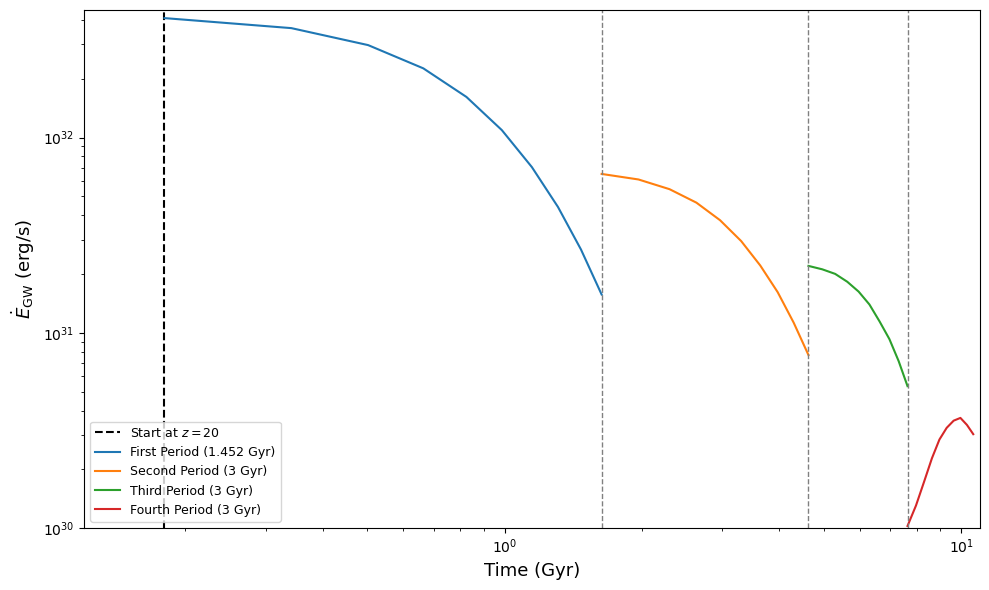

In [318]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Construir el array E_dot_periods ---

N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]              # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]       # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]     # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]     # Cuarto periodo

# Separar en arrays individuales
E_dot_period1 = E_dot_periods[:, 0]
E_dot_period2 = E_dot_periods[:, 1]
E_dot_period3 = E_dot_periods[:, 2]
E_dot_period4 = E_dot_periods[:, 3]

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

# Considerar que partimos en z=20 => tiempo inicial ≈ 0.18 Gyr
z20_time = 0.18  # Tiempo inicial en Gyr

# Duraciones de cada periodo:
T_period1 = 1.452  # Gyr
T_period2 = 3.0
T_period3 = 3.0
T_period4 = 3.0

# Distribuir uniformemente los N puntos en cada periodo:
time_period1 = np.linspace(z20_time, z20_time + T_period1, N)
time_period2 = np.linspace(z20_time + T_period1, z20_time + T_period1 + T_period2, N)
time_period3 = np.linspace(z20_time + T_period1 + T_period2, z20_time + T_period1 + T_period2 + T_period3, N)
time_period4 = np.linspace(z20_time + T_period1 + T_period2 + T_period3, z20_time + T_period1 + T_period2 + T_period3 + T_period4, N)

# --- 3. Graficar evolución de la emisión de GW con líneas verticales entre periodos ---

plt.figure(figsize=(10,6))

# Línea vertical en el tiempo inicial de z=20
plt.axvline(x=z20_time, color='black', linestyle='--', linewidth=1.5, label=r"Start at $z=20$")


# Asignamos distintos colores para cada periodo
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.plot(time_period1, E_dot_period1, label="First Period (1.452 Gyr)", color=colors[0])
plt.plot(time_period2, E_dot_period2, label="Second Period (3 Gyr)", color=colors[1])
plt.plot(time_period3, E_dot_period3, label="Third Period (3 Gyr)", color=colors[2])
plt.plot(time_period4, E_dot_period4, label="Fourth Period (3 Gyr)", color=colors[3])

# --- 4. Definir líneas verticales: inicio + transiciones entre periodos ---


# Líneas verticales entre periodos
period_boundaries = [
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3
]

for xc in period_boundaries:
    plt.axvline(x=xc, color='grey', linestyle='--', linewidth=1)


plt.xlabel("Time (Gyr)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.xscale('log')
plt.ylim([1e30, 4.5e32])
plt.xlim([0.12, 11])
plt.legend(fontsize=9, loc="best", ncol=1, frameon=True)
plt.tight_layout()
plt.savefig("CHES_5_with_start_z20.pdf", dpi=300, bbox_inches="tight")
plt.show()


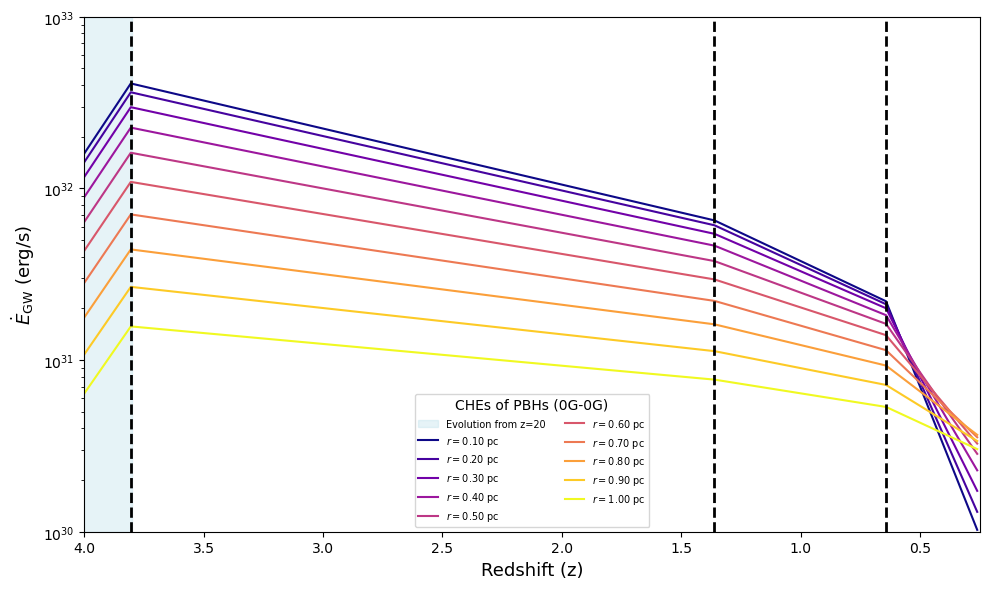

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

# --- 1. Construir el array E_dot_periods ---

N = len(E_dot_CHES_shell)  # Número de radios evaluados

E_dot_periods = np.zeros((N, 4))  # Matriz para guardar las emisiones de cada periodo

for i in range(N):
    E_dot_periods[i, 0] = E_dot_CHES_shell[i]              # Primer periodo
    E_dot_periods[i, 1] = E_dot_CHES_dict["0G-0G"][i]       # Segundo periodo
    E_dot_periods[i, 2] = E_dot_CHES_dict_3["0G-0G"][i]     # Tercer periodo
    E_dot_periods[i, 3] = E_dot_CHES_dict_4["0G-0G"][i]     # Cuarto periodo

# --- 2. Construir arrays de tiempo asociados a cada periodo ---

z20_time = 0.18  # Tiempo inicial en Gyr

# Duraciones de cada periodo:
T_period1 = 1.452
T_period2 = 3.0
T_period3 = 3.0
T_period4 = 3.0

# Tiempos iniciales y finales
time_edges = np.array([
    z20_time,
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3,
    z20_time + T_period1 + T_period2 + T_period3 + T_period4
])

# --- 2.5 Convertir tiempos a redshift usando Astropy ---

z_edges = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in time_edges])

# --- 3. Preparar energía con estado inicial en cero ---

E_dot_periods_with_zero = np.zeros((N, 5))  # Ahora 5 valores (inicio + 4 periodos)
for i in range(N):
    E_dot_periods_with_zero[i, 1:] = E_dot_periods[i, :]
    E_dot_periods_with_zero[i, 0] = 1e-1  # Emisión inicial en z=20

# --- 4. Graficar evolución de cada shell ---

plt.figure(figsize=(10,6))

# Paleta de colores para cada shell
colors = plt.cm.plasma(np.linspace(0, 1, N))
plt.axvspan(20, 3.8, color='lightblue', alpha=0.3, label="Evolution from z=20")

for i in range(N):
    r = r_values_pc[i]
    plt.plot(
        z_edges,
        E_dot_periods_with_zero[i, :],
        color=colors[i],
        label=fr"$r = {r:.2f}\ \mathrm{{pc}}$"
    )

# --- 5. Líneas verticales de separación entre periodos ---

# Línea inicial (inicio en z=20)

z_start = z_at_value(cosmo.age, z20_time * u.Gyr)
#plt.axvline(x=z_start, color='black', linestyle='--', linewidth=1.5, label=r"Start at $z=20$")

# Líneas entre periodos
period_boundaries_time = [
    z20_time + T_period1,
    z20_time + T_period1 + T_period2,
    z20_time + T_period1 + T_period2 + T_period3
]
period_labels = ["1st Period", "2nd Period", "3rd Period"]

for zc, label in zip(period_boundaries_z, period_labels):
    plt.axvline(x=zc, color='black', linestyle='--', linewidth=2)



plt.xlabel("Redshift (z)", fontsize=13)
plt.ylabel(r"$\dot{E}_{\rm GW}$ (erg/s)", fontsize=13)
plt.yscale("log")
plt.gca().invert_xaxis()  # Redshift decreciendo
plt.xlim(4.0, 0.25)
plt.ylim(1e30, 1e33)
# --- Leyenda ---
plt.legend(
    title="CHEs of PBHs (0G-0G)",
    fontsize=7,
    loc="best",
    ncol=2,
    frameon=True,
    title_fontsize=10
)
plt.tight_layout()
plt.savefig("CHES_shells_vs_redshift.pdf", dpi=300, bbox_inches="tight")
plt.show()

